# Temperature Regulation in Molecular Dynamics using Thermostats

This script compares two thermostats Berendsen and Langevin in a molecular dynamics simulation of particles interacting via the Lennard-Jones potential.

## Configuration Parameters (`Configuration` class):
- `dimensions`: Spatial dimensionality (typically 3D)
- `n_particles`: Number of particles in the system
- `density`: Controls the size of the simulation box
- `dt`: Integration timestep
- `steps`: Number of integration steps to simulate
- `temperature`: Target temperature for thermostat control
- `sigma`, `epsilon`: Lennard-Jones interaction parameters
- `rcutoff`: Cutoff radius for force/potential evaluation
- `tau_ber`: Time constant for the Berendsen thermostat
- `gamma_langevin`: Damping coefficient for Langevin dynamics
- `thermostat_type`: Either `'berendsen'` or `'langevin'`

## Key Components:
- `compute_lj_force`, `compute_lj_potential`: Lennard-Jones force and energy with cutoff
- `build_linked_cells`, `compute_forces_lca`: Efficient neighbor listing and force computation using the linked-cell method
- `create_lattice`: Generates initial particle positions in a noisy lattice
- `initialize_velocities`: Randomizes and rescales velocities to match desired temperature
- `apply_berendsen_thermostat`, `apply_langevin_thermostat`: Control temperature via rescaling or stochastic dynamics
- `run_simulation(config)`: Executes the dynamics and applies the selected thermostat

## Simulation:
- Simulates two systems using different thermostats
- Tracks temperature evolution over time
- Plots both time evolution and distributions of temperature for comparison
  
## Parameters:
- `dimensions`: 3  
- `n_particles`: 100  
- `density`: 0.8  
- `dt`: 0.002  
- `steps`: 2000  
- `temperature`: 0.1  
- `sigma`: 1.0  
- `epsilon`: 1.0  
- `rcutoff`: 2.5  
- `tau_ber`: 0.1  
- `gamma_langevin`: 1.0  
- `thermostat_type`: `'berendsen'` and `'langevin'` (both tested)


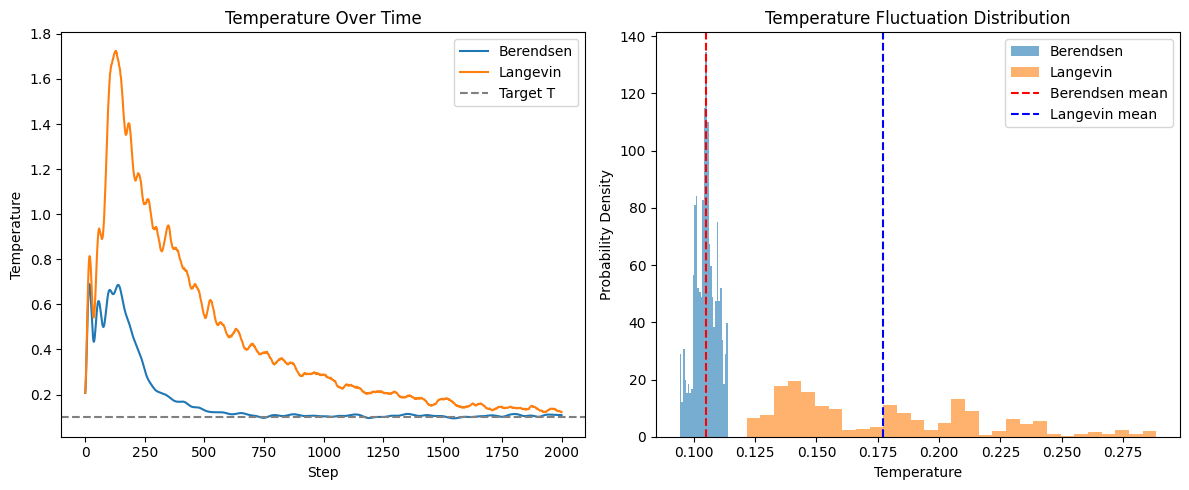

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def compute_lj_force(r, sigma, epsilon, rcutoff):
    if r >= rcutoff or r < 1e-12:
        return 0.0
    inv_r = sigma / r
    inv_r6 = inv_r ** 6
    inv_r12 = inv_r6 ** 2
    return 24 * epsilon * (2 * inv_r12 - inv_r6) / r

def compute_lj_potential(r, sigma, epsilon, rcutoff):
    if r >= rcutoff:
        return 0.0
    inv_r = sigma / r
    inv_r6 = inv_r ** 6
    inv_r12 = inv_r6 ** 2
    pot = 4 * epsilon * (inv_r12 - inv_r6)
    inv_rcut = sigma / rcutoff
    shift = 4 * epsilon * (inv_rcut ** 12 - inv_rcut ** 6)
    return pot - shift

def build_linked_cells(positions, box_size, rcutoff):
    n_particles, dim = positions.shape
    lc = max(1, int(np.floor(box_size / rcutoff)))
    lc_dim = [lc] * dim
    rc = box_size / lc
    EMPTY = -1
    head = [EMPTY] * (lc ** dim)
    lscl = [EMPTY] * n_particles

    for i in range(n_particles):
        mc = [int(positions[i][a] / rc) for a in range(dim)]
        mc = [min(max(0, idx), lc - 1) for idx in mc]
        if dim == 2:
            c_index = mc[0] * lc_dim[1] + mc[1]
        else:
            c_index = mc[0] * lc_dim[1] * lc_dim[2] + mc[1] * lc_dim[2] + mc[2]
        lscl[i] = head[c_index]
        head[c_index] = i

    return head, lscl, lc_dim

def compute_forces_lca(positions, box_size, rcutoff, sigma, epsilon, use_pbc=True):
    n_particles, dim = positions.shape
    head, lscl, lc_dim = build_linked_cells(positions, box_size, rcutoff)
    EMPTY = -1
    forces = np.zeros_like(positions)
    potential_energy = 0.0
    neighbor_offsets = np.array(np.meshgrid(*[[-1, 0, 1]] * dim)).T.reshape(-1, dim)

    for mc in np.ndindex(*lc_dim):
        if dim == 2:
            c_index = mc[0] * lc_dim[1] + mc[1]
        else:
            c_index = mc[0] * lc_dim[1] * lc_dim[2] + mc[1] * lc_dim[2] + mc[2]
        i = head[c_index]
        while i != EMPTY:
            pos_i = positions[i]
            for offset in neighbor_offsets:
                mc1 = np.array(mc) + offset
                rshift = np.zeros(dim)
                valid_cell = True
                for a in range(dim):
                    if use_pbc:
                        if mc1[a] < 0:
                            mc1[a] += lc_dim[a]
                            rshift[a] = -box_size
                        elif mc1[a] >= lc_dim[a]:
                            mc1[a] -= lc_dim[a]
                            rshift[a] = box_size
                    else:
                        if mc1[a] < 0 or mc1[a] >= lc_dim[a]:
                            valid_cell = False
                            break
                if not valid_cell:
                    continue
                if dim == 2:
                    c1 = mc1[0] * lc_dim[1] + mc1[1]
                else:
                    c1 = mc1[0] * lc_dim[1] * lc_dim[2] + mc1[1] * lc_dim[2] + mc1[2]
                j = head[c1]
                while j != EMPTY:
                    if j > i:
                        pos_j = positions[j] + rshift
                        r_ij = pos_i - pos_j
                        dist = np.linalg.norm(r_ij)
                        if dist < rcutoff and dist > 1e-12:
                            f_mag = compute_lj_force(dist, sigma, epsilon, rcutoff)
                            fij = f_mag * (r_ij / dist)
                            forces[i] += fij
                            forces[j] -= fij
                            potential_energy += compute_lj_potential(dist, sigma, epsilon, rcutoff)
                    j = lscl[j]
            i = lscl[i]

    return forces, potential_energy


class Configuration:
    def __init__(self):
        self.dimensions = 3
        self.n_particles = 100
        self.density = 0.8
        self.dt = 0.002
        self.steps = 2000
        self.temperature = 0.1 
        self.sigma = 1.0
        self.epsilon = 1.0
        self.rcutoff = 2.5
        self.tau_ber = 0.1
        self.gamma_langevin = 1.0  
        self.thermostat_type = 'langevin'

def create_lattice(n_particles, box_size, dimensions):
    n_side = int(np.ceil(n_particles ** (1 / dimensions)))
    spacing = box_size / n_side
    positions = []
    for indices in np.ndindex(*([n_side] * dimensions)):
        if len(positions) < n_particles:
            pos = [(i + 0.5) * spacing for i in indices]
            noise = np.random.uniform(-0.05, 0.05, size=dimensions) * spacing
            positions.append(np.array(pos) + noise)
    return np.array(positions)

def initialize_velocities(n_particles, dimensions, target_temp):
    velocities = np.random.normal(0, 1, size=(n_particles, dimensions))
    velocities -= np.mean(velocities, axis=0)
    ke = 0.5 * np.sum(velocities**2)
    dof = n_particles * dimensions
    scale = np.sqrt(target_temp * dof / ke)
    velocities *= scale
    return velocities

def apply_berendsen_thermostat(velocities, target_temp, current_temp, dt, tau):
    lambda_factor = np.sqrt(1 + dt / tau * (target_temp / current_temp - 1))
    return velocities * lambda_factor

def apply_langevin_thermostat(velocities, gamma, dt, target_temp):
    noise = np.random.normal(0, 1, size=velocities.shape)
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt((1 - c1**2) * target_temp)
    return c1 * velocities + c2 * noise


def run_simulation(config):
    box_size = (config.n_particles / config.density) ** (1 / config.dimensions)
    positions = create_lattice(config.n_particles, box_size, config.dimensions)
    velocities = initialize_velocities(config.n_particles, config.dimensions, config.temperature)
    dof = config.n_particles * config.dimensions

    temp_list = []

    for step in range(config.steps):
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)

        velocities += 0.5 * forces * config.dt
        positions += velocities * config.dt
        positions %= box_size 
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)
        velocities += 0.5 * forces * config.dt

        kinetic = 0.5 * np.sum(velocities ** 2)
        temp = 2 * kinetic / dof
        temp_list.append(temp)

        if config.thermostat_type == 'berendsen':
            velocities = apply_berendsen_thermostat(velocities, config.temperature, temp, config.dt, config.tau_ber)
        elif config.thermostat_type == 'langevin':
            velocities = apply_langevin_thermostat(velocities, config.gamma_langevin, config.dt, config.temperature)

    return temp_list


config1 = Configuration()
config1.thermostat_type = 'berendsen'
temps_ber = run_simulation(config1)

config2 = Configuration()
config2.thermostat_type = 'langevin'
temps_lan = run_simulation(config2)

plt.figure(figsize=(12, 5))

# Time evolution
plt.subplot(1, 2, 1)
plt.plot(temps_ber, label='Berendsen')
plt.plot(temps_lan, label='Langevin')
plt.axhline(config1.temperature, linestyle='--', color='gray', label='Target T')
plt.xlabel('Step')
plt.ylabel('Temperature')
plt.title('Temperature Evolution')
plt.grid('Ture')
plt.legend()


plt.subplot(1, 2, 2)
plt.hist(temps_ber[-1000:], bins=30, alpha=0.6, label='Berendsen', density=True)
plt.hist(temps_lan[-1000:], bins=30, alpha=0.6, label='Langevin', density=True)
plt.axvline(np.mean(temps_ber[-1000:]), color='red', linestyle='--', label='Berendsen mean')
plt.axvline(np.mean(temps_lan[-1000:]), color='blue', linestyle='--', label='Langevin mean')
plt.xlabel('Temperature')
plt.ylabel('Probability Density')
plt.title('Temperature Fluctuation Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Thermostat Stability and Parameter Sensitivity in Molecular Dynamics

This code performs a systematic study of temperature control in molecular dynamics simulations using Lennard-Jones interactions.

## Configuration Parameters (`Configuration` class):
- `dimensions`: Spatial dimension of the system (2D or 3D)
- `n_particles`: Total number of particles
- `density`: Number density, used to calculate box size
- `dt`: Integration timestep
- `steps`: Number of simulation steps
- `temperature`: Target temperature
- `sigma`, `epsilon`: Lennard-Jones parameters
- `rcutoff`: Cutoff distance for force/potential
- `tau_ber`, `gamma_langevin`: Thermostat control parameters
- `thermostat_type`: `'berendsen'` or `'langevin'`

## Key Components:
- Lennard-Jones force and potential with cutoff
- Linked-cell algorithm for neighbor list construction
- Velocity initialization and rescaling
- Two thermostats for temperature control
- Temperature monitoring during the simulation

## Simulation:
Evaluation of timestep and thermostat parameter effects on simulation stability and temperature control.

## Parameters:
- `dimensions`: 2 or 3
- `n_particles`: 128
- `density`: 0.8
- `dt`: [0.002, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
- `steps`: 2000
- `temperature`: 0.1
- `sigma`: 1.0
- `epsilon`: 1.0
- `rcutoff`: 2.5
- `tau_ber`: [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 1.0]
- `gamma_langevin`: 1.0
- `thermostat_type`: `'berendsen'` or `'langevin'`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_lj_force(r, sigma, epsilon, rcutoff):
    if r >= rcutoff or r < 1e-12:
        return 0.0
    inv_r = sigma / r
    inv_r6 = inv_r ** 6
    inv_r12 = inv_r6 ** 2
    return 24 * epsilon * (2 * inv_r12 - inv_r6) / r

def compute_lj_potential(r, sigma, epsilon, rcutoff):
    if r >= rcutoff:
        return 0.0
    inv_r = sigma / r
    inv_r6 = inv_r ** 6
    inv_r12 = inv_r6 ** 2
    pot = 4 * epsilon * (inv_r12 - inv_r6)
    inv_rcut = sigma / rcutoff
    shift = 4 * epsilon * (inv_rcut ** 12 - inv_rcut ** 6)
    return pot - shift

def build_linked_cells(positions, box_size, rcutoff):
    n_particles, dim = positions.shape
    lc = max(1, int(np.floor(box_size / rcutoff)))
    lc_dim = [lc] * dim
    rc = box_size / lc
    EMPTY = -1
    head = [EMPTY] * (lc ** dim)
    lscl = [EMPTY] * n_particles

    for i in range(n_particles):
        mc = [int(positions[i][a] / rc) for a in range(dim)]
        mc = [min(max(0, idx), lc - 1) for idx in mc]
        if dim == 2:
            c_index = mc[0] * lc_dim[1] + mc[1]
        else:
            c_index = mc[0] * lc_dim[1] * lc_dim[2] + mc[1] * lc_dim[2] + mc[2]
        lscl[i] = head[c_index]
        head[c_index] = i

    return head, lscl, lc_dim

def compute_forces_lca(positions, box_size, rcutoff, sigma, epsilon, use_pbc=True):
    n_particles, dim = positions.shape
    head, lscl, lc_dim = build_linked_cells(positions, box_size, rcutoff)
    EMPTY = -1
    forces = np.zeros_like(positions)
    potential_energy = 0.0
    neighbor_offsets = np.array(np.meshgrid(*[[-1, 0, 1]] * dim)).T.reshape(-1, dim)

    for mc in np.ndindex(*lc_dim):
        if dim == 2:
            c_index = mc[0] * lc_dim[1] + mc[1]
        else:
            c_index = mc[0] * lc_dim[1] * lc_dim[2] + mc[1] * lc_dim[2] + mc[2]
        i = head[c_index]
        while i != EMPTY:
            pos_i = positions[i]
            for offset in neighbor_offsets:
                mc1 = np.array(mc) + offset
                rshift = np.zeros(dim)
                valid_cell = True
                for a in range(dim):
                    if use_pbc:
                        if mc1[a] < 0:
                            mc1[a] += lc_dim[a]
                            rshift[a] = -box_size
                        elif mc1[a] >= lc_dim[a]:
                            mc1[a] -= lc_dim[a]
                            rshift[a] = box_size
                    else:
                        if mc1[a] < 0 or mc1[a] >= lc_dim[a]:
                            valid_cell = False
                            break
                if not valid_cell:
                    continue
                if dim == 2:
                    c1 = mc1[0] * lc_dim[1] + mc1[1]
                else:
                    c1 = mc1[0] * lc_dim[1] * lc_dim[2] + mc1[1] * lc_dim[2] + mc1[2]
                j = head[c1]
                while j != EMPTY:
                    if j > i:
                        pos_j = positions[j] + rshift
                        r_ij = pos_i - pos_j
                        dist = np.linalg.norm(r_ij)
                        if dist < rcutoff and dist > 1e-12:
                            f_mag = compute_lj_force(dist, sigma, epsilon, rcutoff)
                            fij = f_mag * (r_ij / dist)
                            forces[i] += fij
                            forces[j] -= fij
                            potential_energy += compute_lj_potential(dist, sigma, epsilon, rcutoff)
                    j = lscl[j]
            i = lscl[i]
    return forces, potential_energy

class Configuration:
    def __init__(self, dimensions=3, dt=0.002):
        self.dimensions = dimensions
        self.n_particles = 128
        self.density = 0.8
        self.dt = dt
        self.steps = 2000
        self.temperature = 0.1
        self.sigma = 1.0
        self.epsilon = 1.0
        self.rcutoff = 2.5
        self.tau_ber = 0.1
        self.gamma_langevin = 1.0
        self.thermostat_type = 'langevin'

def create_lattice(n_particles, box_size, dimensions):
    n_side = int(np.ceil(n_particles ** (1 / dimensions)))
    spacing = box_size / n_side
    positions = []
    for indices in np.ndindex(*([n_side] * dimensions)):
        if len(positions) < n_particles:
            pos = [(i + 0.5) * spacing for i in indices]
            noise = np.random.uniform(-0.05, 0.05, size=dimensions) * spacing
            positions.append(np.array(pos) + noise)
    return np.array(positions)

def initialize_velocities(n_particles, dimensions, target_temp):
    velocities = np.random.normal(0, 1, size=(n_particles, dimensions))
    velocities -= np.mean(velocities, axis=0)
    ke = 0.5 * np.sum(velocities**2)
    dof = n_particles * dimensions
    scale = np.sqrt(target_temp * dof / ke)
    velocities *= scale
    return velocities

def apply_berendsen_thermostat(velocities, target_temp, current_temp, dt, tau):
    lambda_factor = np.sqrt(1 + dt / tau * (target_temp / current_temp - 1))
    return velocities * lambda_factor

def apply_langevin_thermostat(velocities, gamma, dt, target_temp):
    noise = np.random.normal(0, 1, size=velocities.shape)
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt((1 - c1**2) * target_temp)
    return c1 * velocities + c2 * noise

def run_simulation(config):
    box_size = (config.n_particles / config.density) ** (1 / config.dimensions)
    positions = create_lattice(config.n_particles, box_size, config.dimensions)
    velocities = initialize_velocities(config.n_particles, config.dimensions, config.temperature)
    dof = config.n_particles * config.dimensions
    temp_list = []

    for step in range(config.steps):
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)
        velocities += 0.5 * forces * config.dt
        positions += velocities * config.dt
        positions %= box_size
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)
        velocities += 0.5 * forces * config.dt

        kinetic = 0.5 * np.sum(velocities ** 2)
        temp = 2 * kinetic / dof
        temp_list.append(temp)

        if config.thermostat_type == 'berendsen':
            velocities = apply_berendsen_thermostat(velocities, config.temperature, temp, config.dt, config.tau_ber)
        elif config.thermostat_type == 'langevin':
            velocities = apply_langevin_thermostat(velocities, config.gamma_langevin, config.dt, config.temperature)

    return temp_list
    

timesteps = [0.002, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
dimensions_list = [2, 3]
results = {}

print("Timestep stability:\n")

for dims in dimensions_list:
    for dt in timesteps:
        config = Configuration(dimensions=dims, dt=dt)
        config.thermostat_type = 'langevin'
        try:
            temps = run_simulation(config)
            temps = np.array(temps)
            stable = (
                not np.any(np.isnan(temps)) and
                not np.any(np.isinf(temps)) and
                np.mean(temps[-100:]) < 10
            )
            if stable:
                print(f"Stable:  dt = {dt:.3f}, dims = {dims}, mean T = {np.mean(temps[-100:]):.4f}")
                results[(dims, dt)] = temps
            else:
                print(f"Unstable: dt = {dt:.3f}, dims = {dims}")
                results[(dims, dt)] = None
        except Exception as e:
            print(f"Error:     dt = {dt:.3f}, dims = {dims}, reason: {e}")
            results[(dims, dt)] = None

for dims in dimensions_list:
    plt.figure(figsize=(10, 6))
    for dt in timesteps:
        key = (dims, dt)
        if results[key] is not None:
            plt.plot(results[key], label=f'dt={dt}')
    plt.title(f'Temperature Evolution in {dims}D')
    plt.xlabel('Step')
    plt.ylabel('Temperature')
    plt.axhline(0.1, linestyle='--', color='gray', label='Target T')
    plt.legend()
    plt.tight_layout()
    plt.show()


thermostat_type = 'berendsen' 
dimension = 3
dt = 0.01
parameter_values = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 1.0]
steps = 2000
results = {}

print(f"\n Testing effect of {'τ' if thermostat_type == 'berendsen' else 'γ'} on temperature control:\n")

for param in parameter_values:
    config = Configuration(dimensions=dimension, dt=dt)
    config.steps = steps
    config.thermostat_type = thermostat_type
    if thermostat_type == 'berendsen':
        config.tau_ber = param
    else:
        config.gamma_langevin = param

    try:
        temps = run_simulation(config)
        temps = np.array(temps)
        stable = (
            not np.any(np.isnan(temps)) and
            not np.any(np.isinf(temps)) and
            np.mean(temps[-100:]) < 10
        )
        if stable:
            print(f" Stable: {thermostat_type} param = {param}, mean T = {np.mean(temps[-100:]):.4f}")
            results[param] = temps
        else:
            print(f"  Unstable or overheated: {param}")
            results[param] = None
    except Exception as e:
        print(f" Error at param={param}: {e}")
        results[param] = None

plt.figure(figsize=(10, 6))
for param, temps in results.items():
    if temps is not None:
        label = f"{'τ' if thermostat_type == 'berendsen' else 'γ'} = {param}"
        plt.plot(temps, label=label)

plt.title(f"Temperature vs Time for {thermostat_type.capitalize()} Thermostat")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.axhline(0.1, linestyle="--", color="gray", label="Target T")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Thermostat Effects on Diffusion and Temperature in Molecular Dynamics

This code compares the influence of different thermostats NVE, Berendsen, and Langevin on particle diffusion and temperature regulation in molecular dynamics simulations. It computes both the temperature evolution and mean squared displacement (MSD) over time for each method.

## Configuration Parameters (`Configuration` class):
- `dimensions`: Spatial dimension of the system (3D used here)
- `n_particles`: Total number of particles
- `density`: Number density, used to compute box size
- `dt`: Integration timestep
- `steps`: Number of simulation steps
- `temperature`: Target temperature
- `sigma`, `epsilon`: Lennard-Jones parameters
- `rcutoff`: Cutoff distance for interactions
- `tau_ber`, `gamma_langevin`: Thermostat control parameters
- `thermostat_type`: `'none'`, `'berendsen'`, or `'langevin'`

## Key Components:
- Initialization of particle positions on a noisy lattice
- Velocity rescaling to match the target temperature
- Lennard-Jones interactions with linked-cell neighbor lists
- Optional thermostat application per timestep
- Real-time tracking of MSD and temperature
- Statistical analysis of temperature fluctuations

## Simulation:
Assessment of how different thermostats influence diffusion and temperature stability over time.

## Parameters:
- `dimensions`: 3
- `n_particles`: 100
- `density`: 0.8
- `dt`: 0.01
- `steps`: 1000
- `temperature`: 0.1
- `sigma`: 1.0
- `epsilon`: 1.0
- `rcutoff`: 2.5
- `tau_ber`: 0.1
- `gamma_langevin`: 1.0
- `thermostat_type`: `'none'`, `'berendsen'`, `'langevin'`


In [ ]:
class Configuration:
    def __init__(self, dimensions=3, dt=0.002):
        self.dimensions = dimensions
        self.n_particles = 100
        self.density = 0.8
        self.dt = dt
        self.steps = 2000
        self.temperature = 0.1
        self.sigma = 1.0
        self.epsilon = 1.0
        self.rcutoff = 2.5
        self.tau_ber = 0.1
        self.gamma_langevin = 1.0
        self.thermostat_type = 'langevin'

def create_lattice(n_particles, box_size, dimensions):
    n_side = int(np.ceil(n_particles ** (1 / dimensions)))
    spacing = box_size / n_side
    positions = []
    for indices in np.ndindex(*([n_side] * dimensions)):
        if len(positions) < n_particles:
            pos = [(i + 0.5) * spacing for i in indices]
            noise = np.random.uniform(-0.05, 0.05, size=dimensions) * spacing
            positions.append(np.array(pos) + noise)
    return np.array(positions)

def initialize_velocities(n_particles, dimensions, target_temp):
    velocities = np.random.normal(0, 1, size=(n_particles, dimensions))
    velocities -= np.mean(velocities, axis=0)
    ke = 0.5 * np.sum(velocities**2)
    dof = n_particles * dimensions
    scale = np.sqrt(target_temp * dof / ke)
    velocities *= scale
    return velocities

def apply_berendsen_thermostat(velocities, target_temp, current_temp, dt, tau):
    lambda_factor = np.sqrt(1 + dt / tau * (target_temp / current_temp - 1))
    return velocities * lambda_factor

def apply_langevin_thermostat(velocities, gamma, dt, target_temp):
    noise = np.random.normal(0, 1, size=velocities.shape)
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt((1 - c1**2) * target_temp)
    return c1 * velocities + c2 * noise

def run_simulation(config):
    box_size = (config.n_particles / config.density) ** (1 / config.dimensions)
    positions = create_lattice(config.n_particles, box_size, config.dimensions)
    velocities = initialize_velocities(config.n_particles, config.dimensions, config.temperature)
    dof = config.n_particles * config.dimensions
    temp_list = []

    for step in range(config.steps):
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)
        velocities += 0.5 * forces * config.dt
        positions += velocities * config.dt
        positions %= box_size
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)
        velocities += 0.5 * forces * config.dt

        kinetic = 0.5 * np.sum(velocities ** 2)
        temp = 2 * kinetic / dof
        temp_list.append(temp)

        if config.thermostat_type == 'berendsen':
            velocities = apply_berendsen_thermostat(velocities, config.temperature, temp, config.dt, config.tau_ber)
        elif config.thermostat_type == 'langevin':
            velocities = apply_langevin_thermostat(velocities, config.gamma_langevin, config.dt, config.temperature)

    return temp_list


def run_simulation_with_msd(config):
    box_size = (config.n_particles / config.density) ** (1 / config.dimensions)
    positions = create_lattice(config.n_particles, box_size, config.dimensions)
    velocities = initialize_velocities(config.n_particles, config.dimensions, config.temperature)
    initial_positions = positions.copy()
    dof = config.n_particles * config.dimensions

    temp_list = []
    msd_list = []

    for step in range(config.steps):
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)

        velocities += 0.5 * forces * config.dt
        positions += velocities * config.dt
        positions %= box_size
        forces, _ = compute_forces_lca(positions, box_size, config.rcutoff,
                                       config.sigma, config.epsilon, use_pbc=True)
        velocities += 0.5 * forces * config.dt

        kinetic = 0.5 * np.sum(velocities ** 2)
        temp = 2 * kinetic / dof
        temp_list.append(temp)

        if config.thermostat_type == 'berendsen':
            velocities = apply_berendsen_thermostat(velocities, config.temperature, temp, config.dt, config.tau_ber)
        elif config.thermostat_type == 'langevin':
            velocities = apply_langevin_thermostat(velocities, config.gamma_langevin, config.dt, config.temperature)

        displacement = positions - initial_positions
        displacement -= box_size * np.round(displacement / box_size)  # PBC
        squared_displacement = np.sum(displacement ** 2, axis=1)
        msd = np.mean(squared_displacement)
        msd_list.append(msd)

    return temp_list, msd_list


names = ['nve', 'berendsen', 'langevin']
thermostats = [None, 'berendsen', 'langevin']
colors = ['gray', 'red', 'blue']

results_temp = {}
results_msd = {}

for name, method in zip(names, thermostats):
    cfg = Configuration(dt=0.01)
    cfg.thermostat_type = method if method else 'none'
    cfg.steps = 1000
    temps, msds = run_simulation_with_msd(cfg)
    results_temp[name] = temps
    results_msd[name] = msds
    print(f"{name.upper()} done: Final T = {np.mean(temps[-100:]):.4f}, Final MSD = {msds[-1]:.4f}")

plt.figure(figsize=(8, 5))
for name, color in zip(names, colors):
    plt.plot(results_msd[name], label=name.capitalize(), color=color)
plt.xlabel("Step")
plt.ylabel("MSD")
plt.title("MSD vs Simulation Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
for name, color in zip(names, colors):
    real_time = np.arange(len(results_msd[name])) * 0.01 
    plt.plot(real_time, results_msd[name], label=name.capitalize(), color=color)
plt.xlabel("Real Time")
plt.ylabel("MSD")
plt.title("MSD vs Real Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

for name, color in zip(names, colors):
    temps = np.array(results_temp[name])
    mean_T = np.mean(temps[-300:])
    std_T = np.std(temps[-300:])

    plt.figure(figsize=(7, 4))
    plt.hist(temps[-300:], bins=40, alpha=0.7, density=True, color=color, edgecolor='black')
    plt.axvline(mean_T, color='k', linestyle='--', label=f"Mean = {mean_T:.3f}")
    plt.title(f"{name.capitalize()} Temperature Distribution\n(Last 300 Steps)")
    plt.xlabel("Temperature")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
